In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import os
import struct
import nltk
#nltk.download() 
from nltk.tag import pos_tag # pos_tag shows the characteristic of a word 
                             # using information in the database

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics.pairwise import cosine_similarity
# Install Empath tool for analyzing text across lexical categories
import sys
!{sys.executable} -m pip install empath
from empath import Empath

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
# Remove some minor problems in form.
def small_clean(text):
    text = text.replace('b\'', '')
    text = text.replace('b"', '')
    text = text.replace('*', '')
    return text

In [4]:
# Single words that we think may be meaningful.
good_pos_tag_set = set(['JJ','JJR','JJS', # adjective
                        'NN','NNP','NNS','NNPS', # noun
                        'RB','RBR','RBS','RP', # adverb and particle
                        'VB','VBD','VBG','VBN','VBP','VBZ']) # verb

In [5]:
# The following two functions are used to help extract terminology and meaningful words
# REFERENCE: http://bdewilde.github.io/blog/2014/09/23/intro-to-automatic-keyphrase-extraction/
def extract_candidate_chunks(text, grammar=r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'):
    import itertools, nltk, string

    # exclude candidates that are stop words or entirely punctuation
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # tokenize, POS-tag, and chunk using regular expressions
    chunker = nltk.chunk.regexp.RegexpParser(grammar)
    tagged_sents = nltk.pos_tag_sents(nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text))
    all_chunks = list(itertools.chain.from_iterable(nltk.chunk.tree2conlltags(chunker.parse(tagged_sent))
                                                    for tagged_sent in tagged_sents))
    # join constituent chunk words into a single chunked phrase
    candidates = [' '.join(word for word, pos, chunk in group).lower()
                  for key, group in itertools.groupby(all_chunks, lambda (word,pos,chunk): chunk != 'O') if key]

    return [cand for cand in candidates
            if cand not in stop_words and not all(char in punct for char in cand)]

def extract_candidate_words(text, good_tags=good_pos_tag_set):
    import itertools, nltk, string

    # exclude candidates that are stop words or entirely punctuation
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # tokenize and POS-tag words
    tagged_words = itertools.chain.from_iterable(nltk.pos_tag_sents(nltk.word_tokenize(sent)
                                                                    for sent in nltk.sent_tokenize(text)))
    # filter on certain POS tags and lowercase all words
    candidates = [word.lower() for word, tag in tagged_words
                  if tag in good_tags and word.lower() not in stop_words
                  and not all(char in punct for char in word)]

    return candidates

# Pack the word extraction process. Return the list of terms and good words
def tokenize_pack(text):
    text = small_clean(text)
    wordlist = extract_candidate_words(text, good_tags=good_pos_tag_set)
    termlist = extract_candidate_chunks(text, grammar=r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}')
    finallist = wordlist + termlist
    return finallist

In [6]:
df = pd.read_csv("./data/Combined_News_DJIA.csv", header = 0, index_col = 0)

In [7]:
headlines = df.as_matrix(columns = df.columns[1:]) 

In [8]:
headlines =[' '.join(map(str, headline)) for headline in headlines]

In [9]:
for i in range(len(headlines)):
    headlines[i] = small_clean(headlines[i])

In [10]:
headlines_train = headlines[:1500]
headlines_test = headlines[1500:]
DJIA_train = df.Label[:1500].values
DJIA_test = df.Label[1500:].values

In [11]:
# TfidfVectorizer
# Exclude the extremely high frequency words/phases and extremely low frequency words/phases.
tfidfvectorizer_word_candidate = TfidfVectorizer(min_df=0.03, max_df=0.2, max_features = 200000, ngram_range = (1, 1))
tfidfvectorizer_phase_candidate = TfidfVectorizer(min_df=0.03, max_df=0.2, max_features = 200000, ngram_range = (2, 5))
train_word_document_matrix_tfidf = tfidfvectorizer_word_candidate.fit_transform(headlines_train)
test_word_document_matrix_tfidf = tfidfvectorizer_word_candidate.transform(headlines_test)
train_phase_document_matrix_tfidf = tfidfvectorizer_phase_candidate.fit_transform(headlines_train)
test_phase_document_matrix_tfidf = tfidfvectorizer_phase_candidate.transform(headlines_test)
print train_word_document_matrix_tfidf.shape
print test_word_document_matrix_tfidf.shape
print train_phase_document_matrix_tfidf.shape
print test_phase_document_matrix_tfidf.shape

(1500, 1778)
(489, 1778)
(1500, 694)
(489, 694)


In [12]:
word_candidate_list = tfidfvectorizer_word_candidate.get_feature_names()
word_final_list = []
for i in range(len(word_candidate_list)):
    posTag = pos_tag([str(word_candidate_list[i])])[0][1]
    isGood = (good_pos_tag_set.union([posTag])==good_pos_tag_set)
    if isGood:
        word_final_list.append(str(word_candidate_list[i]))
print len(word_candidate_list)
print len(word_final_list)

1778
1689


In [13]:
phase_candidate_list = tfidfvectorizer_phase_candidate.get_feature_names()
phase_final_list = []
phase_all_text = ""
for i in range(len(phase_candidate_list)):
    phase_all_text = phase_all_text + ", " + str(phase_candidate_list[i])
    
phase_final_list = extract_candidate_chunks(phase_all_text, grammar=r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}')
print len(phase_candidate_list)
print len(phase_final_list)

694
331


In [14]:
final_vocabulary = set(word_final_list + phase_final_list)
print len(final_vocabulary)
print final_vocabulary

1827
set(['protest', 'asian', 'controversial', 'oldest', 'hate', 'looking', 'votes', 'electricity', 'edward', 'voted', 'worth', 'rescue', 'rise', 'stolen', 'school', 'prize', 'called', 'companies', 'solution', 'monsanto', 'announced', 'force', 'leaders', 'blasphemy', 'warns', 'direct', 'holocaust', 'talks', 'likely', 'street', 'estimated', 'neo', 'beaten', 'asia', 'toll', 'supplies', 'net', 'ever', 'seeks', 'told', 'reporter', 'never', 'richest', 'here', 'hundreds', 'reported', 'protection', 'china', 'kids', 'daughter', 'employees', 'changed', 'envoy', 'reports', 'credit', 'military', 'gay marriage', 'criticism', 'campaign', 'hamas', 'brought', 'turning', 'actions', 'cocaine', 'unit', 'plot', 'dna', 'palestinian', 'hospital', 'arms', 'leaks', 'call', 'telegraph', 'strike', 'tell', 'snowden', 'supporters', 'holy', 'warn', 'phone', 'berlin', 'flotilla', 'hold', 'blocking', 'shoot', 'join', 'work', 'refusing', 'first time', 'era', 'mr', 'president', 'give', 'india', 'currency', 'want', 'd

In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
sia.polarity_scores("I have an apple")

TypeError: unbound method polarity_scores() must be called with SentimentIntensityAnalyzer instance as first argument (got str instance instead)

In [16]:
tfidfvectorizer_final = TfidfVectorizer(vocabulary = final_vocabulary, ngram_range = (1, 5))
train_term_document_matrix_tfidf = tfidfvectorizer_final.fit_transform(headlines_train)
test_term_document_matrix_tfidf = tfidfvectorizer_final.transform(headlines_test)
print train_term_document_matrix_tfidf.shape
print test_term_document_matrix_tfidf.shape

(1500, 1827)
(489, 1827)


In [17]:
# Two benchmarks of accuracy:
# 1. percentage of market up on test days.
float(sum(DJIA_test))/len(headlines_test)

0.5173824130879345

In [18]:
# 2. accuracy of daily reversal prediction on test days.
dl = np.array(DJIA_test)
dl_p = np.zeros(len(dl))
dl_p[0] = df.Label[1499]
s = 0
for i in range(len(dl)):
    if (i!=0):dl_p[i] = dl[i-1]
    if (dl_p[i]==dl[i]):
        s = s+1
print 1-float(s)/len(dl)

0.533742331288


In [19]:
# CountVectorizer(N\A)
# basicvectorizer = CountVectorizer(ngram_range=(3,3))
# train_term_document_matrix_basic = basicvectorizer.fit_transform(headlines_train)
# test_term_document_matrix_basic = basicvectorizer.transform(headlines_test)

In [18]:
from sklearn.linear_model import LogisticRegression
# LASSO
logit = LogisticRegression(penalty='l1')
logit_fit = logit.fit(train_term_document_matrix_tfidf, DJIA_train)
logit_predict = logit.predict(test_term_document_matrix_tfidf)
accu = sum(DJIA_test == logit_predict)/float(len(DJIA_test))
accu

0.50715746421267893

### KNN

In [19]:
def KNN(X_train, Y_train, X_test, Y_test, K):
    """
    X_train: term_doc_matrix
    Y_train: list
    X_test: term_doc_matrix
    Y_test: list
    K: integer
    """
    pred = np.zeros(len(Y_test), dtype = 'int64')
    inverted_index_test = { i[0]:i[1] for i in list(zip(range(len(Y_test)),Y_test))}
    inverted_index_train= { i[0]:i[1] for i in list(zip(range(len(Y_train)),Y_train))}
    sim_score_matrix_K =  cosine_similarity(X_test, X_train)
    for j in range(sim_score_matrix_K.shape[0]):
        highest_K_score_index = np.argsort(sim_score_matrix_K[j])[-K:]
        DJIA_K = [inverted_index_train[idx] for idx in highest_K_score_index]
        Prob = (sum(DJIA_K)+0.)/len(DJIA_K) #smoothing
        if Prob >= 0.5:
            pred[j] = 1
        else:
            pred[j] = 0
    accu = np.mean(Y_test == pred)
    return accu

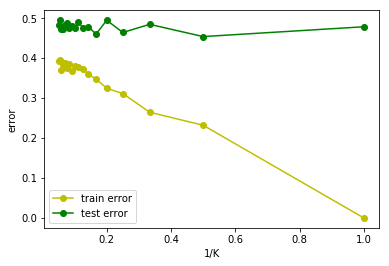

In [20]:
# TfidfVectorizer
train_error =[1- KNN(train_term_document_matrix_tfidf, DJIA_train, train_term_document_matrix_tfidf, DJIA_train, K) for K in range(1, 20)]
test_error = [1- KNN(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test, K) for K in range(1, 20)]
one_over_k = [1.0/K for K in range(1, 20)]
plt.plot(one_over_k, train_error, '-yo', label = 'train error')
plt.plot(one_over_k, test_error, '-go', label = 'test error')
plt.ylabel('error')
plt.xlabel('1/K')
plt.legend(loc = 'lower left')

In [21]:
#For example, when K=5, the corresponding training and test errors are:
print "training error:",1- KNN(train_term_document_matrix_tfidf, DJIA_train, train_term_document_matrix_tfidf, DJIA_train, K)
print "test error:",1- KNN(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test, K)

training error: 0.393333333333
test error: 0.482617586912


### Logistic

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
logit = LogisticRegression()
logit_fit = logit.fit(train_term_document_matrix_tfidf, DJIA_train)
logit_predict = logit.predict(test_term_document_matrix_tfidf)
accu = sum(DJIA_test == logit_predict)/float(len(DJIA_test))
accu

0.4887525562372188

In [24]:
# LASSO
logit = LogisticRegression(penalty='l1')
logit_fit = logit.fit(train_term_document_matrix_tfidf, DJIA_train)
logit_predict = logit.predict(test_term_document_matrix_tfidf)
accu = sum(DJIA_test == logit_predict)/float(len(DJIA_test))
accu

0.50715746421267893

In [25]:
# Ridge
logit = LogisticRegression(penalty='l2')
logit_fit = logit.fit(train_term_document_matrix_tfidf, DJIA_train)
logit_predict = logit.predict(test_term_document_matrix_tfidf)
accu = sum(DJIA_test == logit_predict)/float(len(DJIA_test))
accu

0.4887525562372188

### Rocchio Classification

In [26]:
def Rocchio(X_train, Y_train, X_test, Y_test):
    """
    X_train: term_doc_matrix
    Y_train: list
    X_test: term_doc_matrix
    Y_test: list
    """
    pred = np.zeros(len(Y_test), dtype = 'int64')
    X_train_1 = X_train[np.array(Y_train) == 1, :]
    X_train_0 = X_train[np.array(Y_train) == 0, :]
    Centriod_1 = (np.sum(X_train_1, axis = 0)+0.)/X_train_1.shape[0]
    Centriod_0 = (np.sum(X_train_0, axis = 0)+0.)/X_train_0.shape[0]
    for j in range(len(Y_test)):
        distance_1 = np.sqrt(np.sum(np.square(X_test[j]-Centriod_1)))
        distance_0 = np.sqrt(np.sum(np.square(X_test[j]-Centriod_0)))
        if distance_1 <= distance_0:
            pred[j] = 1
        else:
            pred[j] = 0
    accu = np.mean(Y_test == pred)
    return accu

In [27]:
# test_accuracy
Rocchio(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test)

0.50920245398773001

In [28]:
# train_accuracy
Rocchio(train_term_document_matrix_tfidf, DJIA_train, train_term_document_matrix_tfidf, DJIA_train)

0.81866666666666665

### Naive Bayes

In [29]:
from sklearn.naive_bayes import BernoulliNB

In [30]:
BNBclassifier = BernoulliNB(alpha=1)
BNBclassifier.fit(train_term_document_matrix_tfidf, DJIA_train)

BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)

In [31]:
BNBpred = BNBclassifier.predict(test_term_document_matrix_tfidf)
np.mean(BNBpred==DJIA_test)

0.48057259713701433

### Evaluation

In [32]:
BNBclassifier.classes_

array([0, 1], dtype=int64)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
print(confusion_matrix(DJIA_test, BNBpred))

[[ 79 157]
 [ 97 156]]


In [35]:
print(classification_report(DJIA_test, BNBpred))

             precision    recall  f1-score   support

          0       0.45      0.33      0.38       236
          1       0.50      0.62      0.55       253

avg / total       0.47      0.48      0.47       489



In [36]:
down_probs=BNBclassifier.feature_log_prob_[0,:]

up_probs=BNBclassifier.feature_log_prob_[1,:]

In [37]:
logodds=down_probs-up_probs

In [38]:
terms = tfidfvectorizer.get_feature_names()

NameError: name 'tfidfvectorizer' is not defined

In [39]:
print("\nFeatures that are most indicative of DJIA_UP:\n")
for i in np.argsort(logodds)[:10]:
    print(terms[i])
    
print("\n\nFeatures that are most indicative of DJIA_DOWN\n")
for i in np.argsort(-logodds)[:10]:
    print(terms[i])


Features that are most indicative of DJIA_UP:



NameError: name 'terms' is not defined

### Empath Tool Text Analysis

In [40]:
lexicon = Empath()

In [41]:
df.iloc[1,1]

"b'Why wont America and Nato help us? If they wont help us now, why did we help them in Iraq?'"

In [42]:
lexicon.analyze(df.iloc[1,1], normalize=True)

{'achievement': 0.0,
 'affection': 0.0,
 'aggression': 0.0,
 'air_travel': 0.0,
 'alcohol': 0.0,
 'ancient': 0.0,
 'anger': 0.0,
 'animal': 0.0,
 'anonymity': 0.0,
 'anticipation': 0.0,
 'appearance': 0.0,
 'art': 0.0,
 'attractive': 0.0,
 'banking': 0.0,
 'beach': 0.0,
 'beauty': 0.0,
 'blue_collar_job': 0.0,
 'body': 0.0,
 'breaking': 0.0,
 'business': 0.0,
 'car': 0.0,
 'celebration': 0.0,
 'cheerfulness': 0.0,
 'childish': 0.0,
 'children': 0.0,
 'cleaning': 0.0,
 'clothing': 0.0,
 'cold': 0.0,
 'college': 0.0,
 'communication': 0.0,
 'competing': 0.0,
 'computer': 0.0,
 'confusion': 0.05,
 'contentment': 0.0,
 'cooking': 0.0,
 'crime': 0.0,
 'dance': 0.0,
 'death': 0.0,
 'deception': 0.0,
 'disappointment': 0.0,
 'disgust': 0.0,
 'dispute': 0.0,
 'divine': 0.0,
 'domestic_work': 0.0,
 'dominant_heirarchical': 0.0,
 'dominant_personality': 0.0,
 'driving': 0.0,
 'eating': 0.0,
 'economics': 0.0,
 'emotional': 0.0,
 'envy': 0.0,
 'exasperation': 0.0,
 'exercise': 0.0,
 'exotic': 0.0

In [43]:
df.iloc[2,2]

'b"Russia \'ends Georgia operation\'"'

In [44]:
lexicon.analyze(df.iloc[2,2], normalize=True)

{'achievement': 0.0,
 'affection': 0.0,
 'aggression': 0.0,
 'air_travel': 0.0,
 'alcohol': 0.0,
 'ancient': 0.0,
 'anger': 0.0,
 'animal': 0.0,
 'anonymity': 0.0,
 'anticipation': 0.0,
 'appearance': 0.0,
 'art': 0.0,
 'attractive': 0.0,
 'banking': 0.0,
 'beach': 0.0,
 'beauty': 0.0,
 'blue_collar_job': 0.0,
 'body': 0.0,
 'breaking': 0.0,
 'business': 0.0,
 'car': 0.0,
 'celebration': 0.0,
 'cheerfulness': 0.0,
 'childish': 0.0,
 'children': 0.0,
 'cleaning': 0.0,
 'clothing': 0.0,
 'cold': 0.0,
 'college': 0.0,
 'communication': 0.0,
 'competing': 0.0,
 'computer': 0.0,
 'confusion': 0.0,
 'contentment': 0.0,
 'cooking': 0.0,
 'crime': 0.0,
 'dance': 0.0,
 'death': 0.0,
 'deception': 0.0,
 'disappointment': 0.0,
 'disgust': 0.0,
 'dispute': 0.0,
 'divine': 0.0,
 'domestic_work': 0.0,
 'dominant_heirarchical': 0.0,
 'dominant_personality': 0.0,
 'driving': 0.0,
 'eating': 0.0,
 'economics': 0.0,
 'emotional': 0.0,
 'envy': 0.0,
 'exasperation': 0.0,
 'exercise': 0.0,
 'exotic': 0.0,

In [45]:
def empath_analyze(doc):
    print (doc)
    result = lexicon.analyze(doc, normalize=True)
    for term, score in result.items():
        if score != 0.:
            print ((term, score))

In [46]:
lexicon.analyze('hit', normalize=True).keys()

['help',
 'office',
 'violence',
 'dance',
 'money',
 'wedding',
 'valuable',
 'domestic_work',
 'sleep',
 'medical_emergency',
 'cold',
 'hate',
 'cheerfulness',
 'aggression',
 'occupation',
 'envy',
 'anticipation',
 'family',
 'crime',
 'attractive',
 'masculine',
 'prison',
 'health',
 'pride',
 'dispute',
 'nervousness',
 'government',
 'weakness',
 'horror',
 'swearing_terms',
 'leisure',
 'suffering',
 'royalty',
 'wealthy',
 'white_collar_job',
 'tourism',
 'furniture',
 'school',
 'magic',
 'beach',
 'journalism',
 'morning',
 'banking',
 'social_media',
 'exercise',
 'night',
 'kill',
 'art',
 'play',
 'computer',
 'college',
 'traveling',
 'stealing',
 'real_estate',
 'home',
 'divine',
 'sexual',
 'fear',
 'monster',
 'irritability',
 'superhero',
 'business',
 'driving',
 'pet',
 'childish',
 'cooking',
 'exasperation',
 'religion',
 'hipster',
 'internet',
 'surprise',
 'reading',
 'worship',
 'leader',
 'independence',
 'movement',
 'body',
 'noise',
 'eating',
 'mediev

In [47]:
categories = list(lexicon.analyze('no', normalize=True).keys())

In [48]:
empath_df = pd.DataFrame()

In [49]:
df.iloc[22, 1:]

Top1     b'Dutch to ban burkas when picking children up...
Top2     b"For 21 years a British man has refused to bu...
Top3       b'War Nerd - Ossetia: all over but the whining'
Top4     b'North Korean Leader Kim Jong-il is Confirmed...
Top5            b'Polish PM Wants Child Abusers Castrated'
Top6                  b'Russian bombers land in Venezuela'
Top7            b'Devastating Landslide Kills 56 in China'
Top8     b'Iran demands UN investigate Israeli "threats...
Top9     b'2 Israeli Human Right Groups: Israel is forc...
Top10    b'125,000 Gorillas Find Haven in Mud Swamp But...
Top11    b'Moroccan blogger insults King, King jails in...
Top12    b'Ralph Peters, the retired US army colonel wh...
Top13                   b"US 'not winning' in Afghanistan"
Top14    b'Earth Policy Institute: Increasing Equality ...
Top15                 b"Israel 'dividing up Palestinians'"
Top16    b'Iran Being Supported by Shell Oil, OMV and M...
Top17    b'Russia sends warplanes on Venezuela training.

In [50]:
def create_empath_df(headlines, lexicon, length, categories):
    """
    df: pd.DataFrame, original headline dataframe
    lexicon: empath object, empath tool
    length: integer, length of the dataframe
    categories: list, list of categories in lexicon
    """
    
    #df_empath = pd.DataFrame(0, index=df.index[:length], columns=categories)
    row_list = []
    for i in range(length):
        row_list.append(lexicon.analyze(headlines[i], normalize=True))
    df_empath = pd.DataFrame(row_list, index=df.index[:length])
    return df_empath

In [51]:
df_empath = create_empath_df(headlines, lexicon, len(headlines), categories)

In [52]:
df_empath.head()

,achievement,affection,aggression,air_travel,alcohol,ancient,anger,animal,anonymity,anticipation,...,wealthy,weapon,weather,wedding,white_collar_job,work,worship,writing,youth,zest
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0.002674,0.0,0.002674,0.00000,0.00000,0.002674,0.00000,0.00000,0.0,0.000000,...,0.000000,0.010695,0.000000,0.002674,0.00000,0.002674,0.000000,0.0,0.00000,0.002674
2008-08-11,0.000000,0.0,0.007380,0.00369,0.00369,0.000000,0.00369,0.00000,0.0,0.000000,...,0.000000,0.003690,0.000000,0.003690,0.00000,0.007380,0.000000,0.0,0.00369,0.000000
2008-08-12,0.000000,0.0,0.005698,0.00000,0.00000,0.005698,0.00000,0.00000,0.0,0.000000,...,0.002849,0.002849,0.000000,0.005698,0.00000,0.002849,0.002849,0.0,0.00000,0.000000
2008-08-13,0.000000,0.0,0.006431,0.00000,0.00000,0.003215,0.00000,0.00000,0.0,0.003215,...,0.000000,0.012862,0.006431,0.003215,0.00000,0.006431,0.000000,0.0,0.00000,0.000000
2008-08-14,0.007220,0.0,0.003610,0.00000,0.00361,0.000000,0.00000,0.00361,0.0,0.000000,...,0.000000,0.007220,0.000000,0.003610,0.00361,0.000000,0.000000,0.0,0.00361,0.000000


In [53]:
df_empath.shape

(1989, 194)

In [54]:
df_empath.sum(axis=0).sort_values(ascending = False)

government               18.339678
war                      18.299993
crime                    17.808730
negative_emotion         15.597581
law                      14.585024
leader                   13.674744
fight                    12.857394
business                 11.585098
kill                     11.561819
stealing                 11.329816
money                    10.442449
weapon                   10.129558
military                 10.044834
violence                  9.921086
death                     9.826416
dispute                   9.788707
economics                 9.592128
terrorism                 9.016257
technology                8.623589
prison                    8.509124
aggression                8.280892
banking                   8.278685
power                     8.197165
dominant_heirarchical     8.166643
work                      8.033855
payment                   7.891100
politics                  7.885117
traveling                 6.993661
valuable            

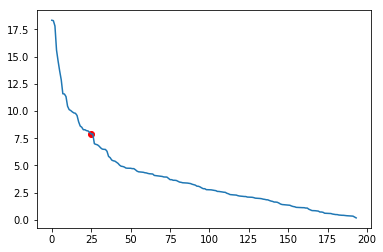

In [55]:
cat_total_scores = df_empath.sum(axis=0).sort_values(ascending = False)
plt.plot(cat_total_scores.values)
plt.scatter(25, cat_total_scores.values[25], color = 'r')

In [56]:
daily_category = df_empath.idxmax(axis=1)

In [57]:
daily_category.value_counts()[:10]

crime               343
government          283
war                 199
negative_emotion    152
business            114
leader               71
law                  67
fight                61
economics            46
money                45
dtype: int64

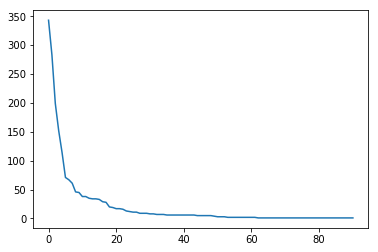

In [58]:
plt.plot(daily_category.value_counts().values)

In [59]:
from collections import defaultdict
cat_to_color = defaultdict(lambda: 'k')

In [60]:
cat_to_color.update({daily_category.value_counts().index[10+i] : 'C'+str(i+1) for i in range(3)})

In [61]:
cat_to_color

defaultdict(<function __main__.<lambda>>,
            {'banking': 'C2', 'dispute': 'C1', 'military': 'C3'})

In [62]:
projected_docs.shape[0]

NameError: name 'projected_docs' is not defined

In [ ]:
daily_category.shape

In [ ]:
color_to_project = defaultdict(list)
for i in range(projected_docs.shape[0]):
    color_to_project[cat_to_color[daily_category[i]]].append(i)

In [ ]:
plt.figure(figsize=(15,15))
for color, indices in color_to_project.items():
    indices = np.array(indices)
    plt.scatter(projected_docs[indices,0], projected_docs[indices,1],
                color = color)
plt.show()

### ML using empath matrix

In [ ]:
train_empath_matrix = df_empath[:1500].as_matrix(columns = df_empath.columns)
test_empath_matrix = df_empath[1500:].as_matrix(columns = df_empath.columns)

In [ ]:
KNN(train_empath_matrix, DJIA_train, test_empath_matrix, DJIA_test, 15)

In [ ]:
Rocchio(train_empath_matrix, DJIA_train, test_empath_matrix, DJIA_test)

In [ ]:
logit = LogisticRegression(penalty='l2')
logit_fit = logit.fit(train_empath_matrix, DJIA_train)
logit_predict = logit.predict(test_empath_matrix)
accu = sum(DJIA_test == logit_predict)/len(DJIA_test)
accu

In [ ]:
BNBclassifier.fit(train_empath_matrix, DJIA_train)
BNBpred = BNBclassifier.predict(test_empath_matrix)
np.mean(BNBpred==DJIA_test)

### LDA topic classification

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
cv = CountVectorizer(stop_words = 'english', vocabulary = final_vocabulary,
                     max_features=6000)
counts = cv.fit_transform(headlines)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [ ]:
n_topic = 15
print(counts.shape)
model = LDA(n_topics=n_topic, max_iter=10, n_jobs=4, verbose=1)
res = model.fit_transform(counts)

In [ ]:
feature_names = cv.get_feature_names()
print_top_words(model, feature_names, 20)

In [ ]:
res.shape

In [ ]:
KNN(X_train=res[:1500, :], Y_train=DJIA_train, X_test=res[1500:, :], Y_test=DJIA_test, K=4)

In [ ]:
Rocchio(X_train=res[:1500, :], Y_train=DJIA_train, X_test=res[1500:, :], Y_test=DJIA_test)

In [ ]:
BNBclassifier.fit(res[:1500, :], DJIA_train)
BNBpred = BNBclassifier.predict(res[1500:, :])
np.mean(BNBpred==DJIA_test)

In [ ]:
logit = LogisticRegression(penalty='l2')
logit_fit = logit.fit(res[:1500, :], DJIA_train)
logit_predict = logit.predict(res[1500: , :])
accu = np.mean(DJIA_test == logit_predict)
accu